In [20]:
###classification without balancing dataset(UK)
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']
print(f"Total records in the dataset: {data.shape[0]}")
print(f"Number of records from the UK: {data_uk.shape[0]}")

# Step 3: Data Cleaning and Feature Engineering
data_cleaned = data_uk.dropna(subset=['CustomerID']).copy()
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['TotalAmount'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
data_cleaned['Recency'] = (data_cleaned['InvoiceDate'].max() - data_cleaned['InvoiceDate']).dt.days

# Aggregate features at the customer level
customer_features = data_cleaned.groupby('CustomerID').agg(
    TotalAmount=('TotalAmount', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    Recency=('Recency', 'min'),
    Frequency=('InvoiceNo', 'nunique'),
    Purchase=('TotalAmount', lambda x: 1 if x.sum() > 0 else 0)  # Define target: Purchase (1/0)
).reset_index()

# Replace zeros or negative values in TotalQuantity and TotalAmount
customer_features['TotalQuantity'] = customer_features['TotalQuantity'].replace(0, 1e-6)
customer_features['TotalAmount'] = customer_features['TotalAmount'].replace(0, 1e-6)

# Log-transform skewed features to reduce outliers
customer_features['Log_TotalQuantity'] = np.log1p(customer_features['TotalQuantity'])
customer_features['Log_TotalAmount'] = np.log1p(customer_features['TotalAmount'])

# Replace infinite and NaN values
customer_features.replace([np.inf, -np.inf], np.nan, inplace=True)
customer_features.dropna(inplace=True)

# Scale numeric features
scaler = MinMaxScaler()
numeric_columns = ['TotalQuantity', 'AvgUnitPrice', 'Recency', 'Frequency', 'Log_TotalQuantity']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Step 4: Define Features (X) and Target (y)
X = customer_features.drop(columns=['CustomerID', 'Purchase', 'TotalAmount', 'Log_TotalAmount'])
y = customer_features['Purchase']

# Check class distribution
print("\nOriginal class distribution (UK data):")
print(y.value_counts())

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train Logistic Regression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')  # Using class weights to handle imbalance
log_reg.fit(X_train, y_train)

# Step 7: Train Random Forest
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=8)
rf_clf.fit(X_train, y_train)

# Step 8: Evaluate Logistic Regression on Original Test Set
print("\nLogistic Regression Evaluation:")
y_pred_log_reg = log_reg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))



# Step 9: Evaluate Random Forest on Original Test Set
print("\nRandom Forest Evaluation:")
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Display first 10 rows of actual vs predicted
print("\nLogistic Regression Prediction:")
log_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_log_reg})
print("\nLogistic Regression: Actual vs Predicted (First 10 Rows):")
print(log_reg_results.head(10))

# Display first 10 rows of actual vs predicted
print("\nRandom Forest Prediction")
rf_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
print("\nRandom Forest: Actual vs Predicted (First 10 Rows):")
print(rf_results.head(10))



Total records in the dataset: 541909
Number of records from the UK: 495478

Original class distribution (UK data):
1    3904
0       8
Name: Purchase, dtype: int64


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depr

LogisticRegression(class_weight='balanced', random_state=42)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)


Logistic Regression Evaluation:
Accuracy: 0.9676
Classification Report:
              precision    recall  f1-score   support

           0       0.05      1.00      0.10         2
           1       1.00      0.97      0.98      1172

    accuracy                           0.97      1174
   macro avg       0.53      0.98      0.54      1174
weighted avg       1.00      0.97      0.98      1174


Random Forest Evaluation:
Accuracy: 0.9983
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      1.00      1.00      1172

    accuracy                           1.00      1174
   macro avg       0.75      1.00      0.83      1174
weighted avg       1.00      1.00      1.00      1174


Logistic Regression Prediction:

Logistic Regression: Actual vs Predicted (First 10 Rows):
      Actual  Predicted
2231       1          1
3431       1          1
574        1          1
136        1      

In [14]:
import pandas as pd

# Step 1: Load the Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path if necessary
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Display Dataset Information
print("\nDataset Overview:")
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

# Step 3: Display Columns
print("\nColumns in the Dataset:")
print(data.columns.tolist())

# Step 4: View First 10 Rows
print("\nFirst 10 Rows of the Dataset:")
print(data.head(10))

# Step 5: Check for Missing Values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())



Dataset Overview:
Number of rows: 541909
Number of columns: 8

Columns in the Dataset:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First 10 Rows of the Dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNA

In [2]:
##Classification after balancing the dataset using SMOTE
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']

# Step 3: Data Cleaning and Feature Engineering
data_cleaned = data_uk.dropna(subset=['CustomerID']).copy()
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['TotalAmount'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
data_cleaned['Recency'] = (data_cleaned['InvoiceDate'].max() - data_cleaned['InvoiceDate']).dt.days

# Aggregate features at the customer level
customer_features = data_cleaned.groupby('CustomerID').agg(
    TotalAmount=('TotalAmount', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    Recency=('Recency', 'min'),
    Frequency=('InvoiceNo', 'nunique'),
    Purchase=('TotalAmount', lambda x: 1 if x.sum() > 0 else 0)  # Target: Purchase (1/0)
).reset_index()

# Replace zeros or negative values in TotalQuantity and TotalAmount
customer_features['TotalQuantity'] = customer_features['TotalQuantity'].replace(0, 1e-6)
customer_features['TotalAmount'] = customer_features['TotalAmount'].replace(0, 1e-6)

# Log-transform skewed features to reduce outliers
customer_features['Log_TotalQuantity'] = np.log1p(customer_features['TotalQuantity'])
customer_features['Log_TotalAmount'] = np.log1p(customer_features['TotalAmount'])

# Replace infinite and NaN values
customer_features.replace([np.inf, -np.inf], np.nan, inplace=True)
customer_features.dropna(inplace=True)

# Scale numeric features
scaler = MinMaxScaler()
numeric_columns = ['TotalQuantity', 'AvgUnitPrice', 'Recency', 'Frequency', 'Log_TotalQuantity']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Step 4: Define Features (X) and Target (y)
X = customer_features.drop(columns=['CustomerID', 'Purchase', 'TotalAmount', 'Log_TotalAmount'])
y = customer_features['Purchase']

# Check class distribution
print("UK dataset class distribution:")
print(y.value_counts())

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Balance Training Data with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nTraining set class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Step 7: Adjust SMOTE for Test Data Based on Minority Class Size
minority_class_samples = sum(y_test == 0)
adjusted_neighbors = max(1, minority_class_samples - 1)  # Ensure valid k_neighbors
smote_test = SMOTE(random_state=42, k_neighbors=adjusted_neighbors)
X_test_smote, y_test_smote = smote_test.fit_resample(X_test, y_test)

print("\nTesting set class distribution after SMOTE:")
print(pd.Series(y_test_smote).value_counts())

# Step 8: Train Logistic Regression with Class Weights
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_smote, y_train_smote)

# Step 9: Train Random Forest with Class Weights
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=8)
rf_clf.fit(X_train_smote, y_train_smote)

# Step 10: Evaluate Logistic Regression on Balanced Test Set
print("\nLogistic Regression Evaluation on SMOTE Balanced Test Set:")
y_pred_log_reg_bal = log_reg.predict(X_test_smote)
print(f"Accuracy: {accuracy_score(y_test_smote, y_pred_log_reg_bal):.4f}")
print("Classification Report:")
print(classification_report(y_test_smote, y_pred_log_reg_bal))

# Step 11: Evaluate Random Forest on Balanced Test Set
print("\nRandom Forest Evaluation on SMOTE Balanced Test Set:")
y_pred_rf_bal = rf_clf.predict(X_test_smote)
print(f"Accuracy: {accuracy_score(y_test_smote, y_pred_rf_bal):.4f}")
print("Classification Report:")
print(classification_report(y_test_smote, y_pred_rf_bal))


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


UK dataset class distribution:
1    3904
0       8
Name: Purchase, dtype: int64

Training set class distribution after SMOTE:
1    2732
0    2732
Name: Purchase, dtype: int64

Testing set class distribution after SMOTE:
1    1172
0    1172
Name: Purchase, dtype: int64

Logistic Regression Evaluation on SMOTE Balanced Test Set:
Accuracy: 0.9842
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1172
           1       1.00      0.97      0.98      1172

    accuracy                           0.98      2344
   macro avg       0.98      0.98      0.98      2344
weighted avg       0.98      0.98      0.98      2344


Random Forest Evaluation on SMOTE Balanced Test Set:
Accuracy: 0.9991
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1172
           1       1.00      1.00      1.00      1172

    accuracy                           1.00   

Total records in the dataset: 541909
Number of records from the UK: 495478


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depr


Regression Models:

Linear Regression Results:
Mean Squared Error (MSE): 23626797.80
R-squared (R²): 0.6594

Linear Regression: Predicted vs Actual Revenue (Sample)
       Actual    Predicted
2965   391.52   291.686059
1981   348.60   321.856981
2450   681.19   483.296559
1444  2456.80  1868.891403
2727   140.70   205.964574
2856   380.39   186.143384
198   1708.86  2697.128431
2364   108.38   279.302189
2672   480.92   560.488632
1459   841.20  1155.266095

Decision Tree Results:
Mean Squared Error (MSE): 25822631.86
R-squared (R²): 0.6277

Decision Tree: Predicted vs Actual Revenue (Sample)
       Actual    Predicted
2965   391.52   321.138171
1981   348.60   433.881723
2450   681.19   683.754821
1444  2456.80  2555.309130
2727   140.70   147.729657
2856   380.39   253.229000
198   1708.86  1510.048333
2364   108.38   147.729657
2672   480.92   511.301384
1459   841.20   905.266460


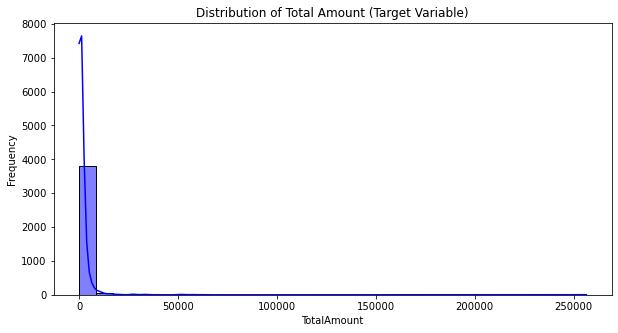

Target Variable Statistics (TotalAmount):
count    3.912000e+03
mean     1.733062e+03
std      6.576868e+03
min     -5.329071e-15
25%      2.907150e+02
50%      6.352550e+02
75%      1.534990e+03
max      2.564385e+05
Name: TotalAmount, dtype: float64


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\array_algos\quantile.py:100: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result = nanpercentile(


In [13]:
#regression for original dataset.
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']
print(f"Total records in the dataset: {data.shape[0]}")
print(f"Number of records from the UK: {data_uk.shape[0]}")

# Step 3: Data Cleaning and Feature Engineering
data_cleaned = data_uk.dropna(subset=['CustomerID']).copy()
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['TotalAmount'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
data_cleaned['Recency'] = (data_cleaned['InvoiceDate'].max() - data_cleaned['InvoiceDate']).dt.days

# Aggregate features at the customer level
customer_features = data_cleaned.groupby('CustomerID').agg(
    TotalAmount=('TotalAmount', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    Recency=('Recency', 'min'),
    Frequency=('InvoiceNo', 'nunique')
).reset_index()

# Replace zeros or negative values in TotalQuantity
customer_features['TotalQuantity'] = customer_features['TotalQuantity'].replace(0, 1e-6)

# Log-transform skewed features to reduce outliers
customer_features['Log_TotalQuantity'] = np.log1p(customer_features['TotalQuantity'])
customer_features['Log_TotalAmount'] = np.log1p(customer_features['TotalAmount'])

# Replace infinite and NaN values
customer_features.replace([np.inf, -np.inf], np.nan, inplace=True)
customer_features.dropna(inplace=True)

# Scale numeric features
scaler = MinMaxScaler()
numeric_columns = ['TotalQuantity', 'AvgUnitPrice', 'Recency', 'Frequency', 'Log_TotalQuantity']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Step 4: Define Features (X) and Target (y)
X = customer_features.drop(columns=['CustomerID', 'TotalAmount', 'Log_TotalAmount'])
y = customer_features['TotalAmount']  # Predicting Total Revenue (continuous target)

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Regression Models
print("\nRegression Models:")

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLinear Regression Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_lr):.2f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred_lr):.4f}")

# Display some predicted vs actual values
print("\nLinear Regression: Predicted vs Actual Revenue (Sample)")
predicted_vs_actual_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
print(predicted_vs_actual_lr.head(10))  # Show first 10 rows

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42, max_depth=8)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nDecision Tree Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_dt):.2f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred_dt):.4f}")

# Display some predicted vs actual values
print("\nDecision Tree: Predicted vs Actual Revenue (Sample)")
predicted_vs_actual_dt = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_dt})
print(predicted_vs_actual_dt.head(10))  # Show first 10 rows

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable (TotalAmount)
plt.figure(figsize=(10, 5))
sns.histplot(customer_features['TotalAmount'], kde=True, bins=30, color='blue')
plt.title("Distribution of Total Amount (Target Variable)")
plt.xlabel("TotalAmount")
plt.ylabel("Frequency")
plt.show()

# Check basic statistics
print("Target Variable Statistics (TotalAmount):")
print(customer_features['TotalAmount'].describe())



Total records in the dataset: 541909
Number of records from the UK: 495478


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\imran\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depr


Regression Models:

Linear Regression Results:
Mean Squared Error (MSE): 0.3400
R-squared (R²): 0.7963

Linear Regression: Predicted vs Actual Revenue (Sample)
        Actual  Predicted
2965  5.972587   6.020212
1981  5.856790   5.563573
2450  6.525308   6.138837
1444  7.807022   7.448620
2727  4.953712   5.097694
2856  5.943822   5.217813
198   7.444167   7.818937
2364  4.694828   5.168811
2672  6.177778   6.364837
1459  6.736018   7.037064

Decision Tree Results:
Mean Squared Error (MSE): 0.2239
R-squared (R²): 0.8659

Decision Tree: Predicted vs Actual Revenue (Sample)
        Actual  Predicted
2965  5.972587   5.978899
1981  5.856790   5.744190
2450  6.525308   6.395194
1444  7.807022   7.745259
2727  4.953712   4.772478
2856  5.943822   5.537600
198   7.444167   6.894070
2364  4.694828   4.587171
2672  6.177778   6.280916
1459  6.736018   6.904008

Gradient Boosting Regressor Results:
Mean Squared Error (MSE): 0.1793
R-squared (R²): 0.8926

Gradient Boosting Regressor: Predicted 

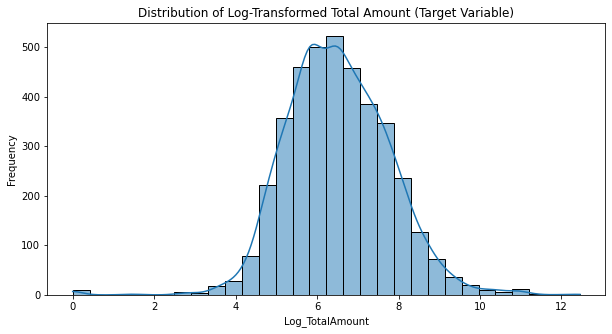

Target Variable Statistics:
count    3.912000e+03
mean     6.510161e+00
std      1.271735e+00
min     -5.329071e-15
25%      5.675777e+00
50%      6.455599e+00
75%      7.336930e+00
max      1.245465e+01
Name: Log_TotalAmount, dtype: float64


C:\Users\imran\anaconda3\lib\site-packages\pandas\core\array_algos\quantile.py:100: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result = nanpercentile(


In [12]:
#log transformation for the target variable
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']
print(f"Total records in the dataset: {data.shape[0]}")
print(f"Number of records from the UK: {data_uk.shape[0]}")

# Step 3: Data Cleaning and Feature Engineering
data_cleaned = data_uk.dropna(subset=['CustomerID']).copy()
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['TotalAmount'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
data_cleaned['Recency'] = (data_cleaned['InvoiceDate'].max() - data_cleaned['InvoiceDate']).dt.days

# Aggregate features at the customer level
customer_features = data_cleaned.groupby('CustomerID').agg(
    TotalAmount=('TotalAmount', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    Recency=('Recency', 'min'),
    Frequency=('InvoiceNo', 'nunique')
).reset_index()

# Replace zeros or negative values in TotalQuantity
customer_features['TotalQuantity'] = customer_features['TotalQuantity'].replace(0, 1e-6)

# Log-transform skewed features and target variable
customer_features['Log_TotalQuantity'] = np.log1p(customer_features['TotalQuantity'])
customer_features['Log_TotalAmount'] = np.log1p(customer_features['TotalAmount'])

# Replace infinite and NaN values
customer_features.replace([np.inf, -np.inf], np.nan, inplace=True)
customer_features.dropna(inplace=True)

# Scale numeric features
scaler = MinMaxScaler()
numeric_columns = ['TotalQuantity', 'AvgUnitPrice', 'Recency', 'Frequency', 'Log_TotalQuantity']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Step 4: Define Features (X) and Target (y)
X = customer_features.drop(columns=['CustomerID', 'TotalAmount', 'Log_TotalAmount'])
y = customer_features['Log_TotalAmount']  # Predicting log-transformed revenue

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Train and Evaluate Models
print("\nRegression Models:")

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLinear Regression Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred_lr):.4f}")

# Display predicted vs actual values for Linear Regression
print("\nLinear Regression: Predicted vs Actual Revenue (Sample)")
predicted_vs_actual_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
print(predicted_vs_actual_lr.head(10))  # Show first 10 rows

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42, max_depth=8)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nDecision Tree Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_dt):.4f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred_dt):.4f}")

# Display predicted vs actual values for Decision Tree Regressor
print("\nDecision Tree: Predicted vs Actual Revenue (Sample)")
predicted_vs_actual_dt = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_dt})
print(predicted_vs_actual_dt.head(10))  # Show first 10 rows


# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=5)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print("\nGradient Boosting Regressor Results:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_gbr):.4f}")
print(f"R-squared (R²): {r2_score(y_test, y_pred_gbr):.4f}")
# Display predicted vs actual values for Gradient Boosting Regressor
print("\nGradient Boosting Regressor: Predicted vs Actual Revenue (Sample)")
predicted_vs_actual_gbr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gbr})
print(predicted_vs_actual_gbr.head(10))  # Show first 10 rows

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 5))
sns.histplot(customer_features['Log_TotalAmount'], kde=True, bins=30)
plt.title("Distribution of Log-Transformed Total Amount (Target Variable)")
plt.xlabel("Log_TotalAmount")
plt.ylabel("Frequency")
plt.show()

# Check basic statistics
print("Target Variable Statistics:")
print(customer_features['Log_TotalAmount'].describe())



In [11]:
#churn prediction
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']

# Step 3: Data Cleaning and Feature Engineering
data_cleaned = data_uk.dropna(subset=['CustomerID']).copy()
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['TotalAmount'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

# Create Recency feature (days since last purchase)
latest_date = data_cleaned['InvoiceDate'].max()
data_cleaned['Recency'] = (latest_date - data_cleaned['InvoiceDate']).dt.days

# Aggregate features at the customer level
customer_features = data_cleaned.groupby('CustomerID').agg(
    TotalAmount=('TotalAmount', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgUnitPrice=('UnitPrice', 'mean'),
    Recency=('Recency', 'min'),
    Frequency=('InvoiceNo', 'nunique')
).reset_index()

# Define Churn (target variable) as Recency > 180 days (example)
customer_features['Churn'] = np.where(customer_features['Recency'] > 180, 1, 0)

# Scale numeric features
scaler = MinMaxScaler()
numeric_columns = ['TotalQuantity', 'AvgUnitPrice', 'Recency', 'Frequency']
customer_features[numeric_columns] = scaler.fit_transform(customer_features[numeric_columns])

# Step 4: Define Features (X) and Target (y)
X = customer_features.drop(columns=['CustomerID', 'Churn', 'TotalAmount'])
y = customer_features['Churn']

# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Train Models
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Step 7: Evaluate Models
# Logistic Regression Results
print("Logistic Regression Evaluation:")
y_pred_log_reg = log_reg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Random Forest Results
print("\nRandom Forest Evaluation:")
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Evaluation:
Accuracy: 0.9975
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      0.99      0.99       233

    accuracy                           1.00      1185
   macro avg       1.00      0.99      1.00      1185
weighted avg       1.00      1.00      1.00      1185


Random Forest Evaluation:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       952
           1       1.00      1.00      1.00       233

    accuracy                           1.00      1185
   macro avg       1.00      1.00      1.00      1185
weighted avg       1.00      1.00      1.00      1185



In [13]:
conda install -c conda-forge mlxtend


Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\imran\anaconda3

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.14.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    mlxtend-0.23.3             |     pyhd8ed1ab_0         1.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  mlxtend            conda-forge/noarch::mlxtend-0.23.3-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.12.0-py39hcbf5309_0 --> 4.14.0-py39hcbf5309_0




mlxtend-0.23.3       | 1.2 MB    |            |   0% 
mlxtend-0.23.3       | 1.2 MB    | 1          | 

In [3]:
import mlxtend
print(mlxtend.__version__)


0.23.3


In [7]:
# Import necessary libraries
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']

# Step 3: Data Cleaning for Association Mining
# Retain relevant columns (InvoiceNo, StockCode, Quantity)
data_cleaned = data_uk[['InvoiceNo', 'StockCode', 'Quantity']].copy()
data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]  # Remove negative quantities

# Create a basket-like structure (transactions by InvoiceNo)
basket = data_cleaned.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket.set_index('InvoiceNo', inplace=True)

# Convert quantities to 1/0 (presence/absence of items)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 4: Perform FP-Growth Algorithm
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)
print("Frequent Itemsets:")
print(frequent_itemsets)

# Step 5: Generate Association Rules with num_itemsets
num_itemsets = len(frequent_itemsets)  # Calculate the number of itemsets
rules = association_rules(frequent_itemsets,num_itemsets=num_itemsets, metric="confidence", min_threshold=0.5)

print("\nAssociation Rules:")
print(rules)
filtered_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.5)]
print(filtered_rules)



C:\Users\imran\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent Itemsets:
       support        itemsets
0     0.112264        (85123A)
1     0.023901        (84029G)
2     0.021931        (84029E)
3     0.018099         (22752)
4     0.017087         (71053)
...        ...             ...
2072  0.012137  (23355, 23356)
2073  0.014053  (22112, 23355)
2074  0.010114  (22633, 23439)
2075  0.011445  (23439, 22865)
2076  0.010380  (22866, 23439)

[2077 rows x 2 columns]

Association Rules:
         antecedents consequents  antecedent support  consequent support  \
0            (22632)     (22865)            0.020068            0.033536   
1            (22632)     (22866)            0.020068            0.028745   
2            (22748)     (22745)            0.019962            0.019376   
3            (22745)     (22748)            0.019376            0.019962   
4     (22961, 22720)     (22960)            0.016715            0.053178   
...              ...         ...                 ...                 ...   
1144         (23295)     (23294)

In [21]:
# Import necessary libraries
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Step 1: Load Dataset
file_path = r"C:\Users\imran\Downloads\data.csv"  # Update the file path
data = pd.read_csv(file_path, encoding='latin1')

# Step 2: Filter Data for UK Customers
data_uk = data[data['Country'] == 'United Kingdom']

# Step 3: Data Cleaning for Association Mining
# Retain relevant columns (InvoiceNo, StockCode, Quantity)
data_cleaned = data_uk[['InvoiceNo', 'StockCode', 'Quantity']].copy()
data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]  # Remove negative quantities

# Create a basket-like structure (transactions by InvoiceNo)
basket = data_cleaned.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket.set_index('InvoiceNo', inplace=True)

# Convert quantities to 1/0 (presence/absence of items)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 4: Perform FP-Growth Algorithm
min_support = 0.02  # You can adjust this threshold
frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
print("Frequent Itemsets:")
print(frequent_itemsets)

# Step 5: Generate Association Rules
num_itemsets = len(frequent_itemsets)  # Calculate the number of itemsets
rules = association_rules(frequent_itemsets,num_itemsets=num_itemsets, metric="confidence", min_threshold=0.6)

# Filter rules for meaningful insights
filtered_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 1.5)]
filtered_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=False)

# Display top association rules
print("\nFiltered Association Rules:")
print(filtered_rules.head(10))  # Show top 10 rules

# Map StockCode to Product Names (if available)
if 'Description' in data.columns:
    product_map = data[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()
    filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: [product_map.get(item, item) for item in x])
    filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: [product_map.get(item, item) for item in x])

    print("\nFiltered Association Rules with Product Names:")
    print(filtered_rules.head(10))

# Save rules to a file for further analysis
filtered_rules.to_csv("association_rules.csv", index=False)


C:\Users\imran\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent Itemsets:
      support         itemsets
0    0.112264         (85123A)
1    0.023901         (84029G)
2    0.021931         (84029E)
3    0.025338          (22633)
4    0.020068          (22632)
..        ...              ...
366  0.025924   (23203, 23202)
367  0.028692  (23203, 85099B)
368  0.024114   (23203, 23209)
369  0.022464   (23209, 20725)
370  0.028798   (23301, 23300)

[371 rows x 2 columns]

Filtered Association Rules:
       antecedents     consequents  antecedent support  consequent support  \
25  (22699, 22697)         (22698)            0.037315            0.037421   
28         (22698)  (22699, 22697)            0.037421            0.037315   
26  (22699, 22698)         (22697)            0.029064            0.049718   
27  (22697, 22698)         (22699)            0.030714            0.050942   
23         (22698)         (22697)            0.037421            0.049718   
24         (22698)         (22699)            0.037421            0.050942   
30        

PermissionError: [Errno 13] Permission denied: 'association_rules.csv'